# Readability Assessment through Learning Techniques

* Readability assessment is a well known problem in natural language processing field. 
* Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. 

In this notebook we are trying to assess the readability of a given text regardless of the text topic.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [1]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings, load_old_corpus
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional,Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np

corpus = load_corpus()
articles_words, tags = corpus_to_words(corpus)
articles_pos, tags = corpus_to_pos(corpus)
old_articles_pos, old_articles_tags = load_old_corpus()

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [2]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles_words[i][:words])], 
        ["Intermediate",detokenize(articles_words[i+2][:words])], 
        ["Elementary",detokenize(articles_words[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 20px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

## Data preprocessing

### 1. Converting words to part of speech tags

In [3]:
print(articles_words[0][:10])
print(articles_pos[0][:10])

['When', 'you', 'see', 'the', 'word', 'Amazon', ',', 'whats', 'the', 'first']
['WRB', 'PRP', 'VB', 'DT', 'NN', 'NN', ',', 'VBZ', 'DT', 'JJ']


### 2. Converting part of speech to sequences

In [4]:
maxlen = 1000 # Cuts off reviews after 1000 words
max_words = 45
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(articles_pos)

In [5]:
sequences = tokenizer.texts_to_sequences(articles_pos)
old_sequences = tokenizer.texts_to_sequences(old_articles_pos)
print(np.shape(sequences))
print(np.shape(old_sequences))

(567,)
(183,)


### 3. Padding

In [6]:
data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
old_data = pad_sequences(old_sequences, maxlen=maxlen, padding='post', truncating='post')
print(np.shape(data))
print(np.shape(old_data))

(567, 1000)
(183, 1000)


In [7]:
tags = np.array(tags)
old_tags = np.array(old_articles_tags)
print(tags.shape)
print(old_tags.shape)

(567,)
(183,)


### 4. Convert sequences to one hot encoding

In [8]:
data = to_categorical(data)
old_data = to_categorical(old_data)
print(data.shape)
print(old_data.shape)

(567, 1000, 45)
(183, 1000, 45)


### 5. Randomize data

In [9]:
np.random.seed(0)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
tags = tags[indices]

old_indices = np.arange(old_data.shape[0])
np.random.shuffle(indices)

old_data = old_data[old_indices]
old_tags = old_tags[old_indices]
print(data.shape)
print(tags.shape)

print(old_data.shape)
print(old_tags.shape)

(567, 1000, 45)
(567,)
(183, 1000, 45)
(183,)


## Structuring the model

In [198]:
model = Sequential()
model.add(Conv1D(128, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(1000,45)))
model.add(MaxPooling1D(10))
model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
def soft_acc(y_true, y_pred):
    from tensorflow.python.keras import backend as K
    return K.mean(K.less(K.abs(y_pred-y_true),0.6))

In [199]:
es = EarlyStopping(monitor='val_soft_acc',patience=100, mode='max')
cp = ModelCheckpoint('model-{epoch:03d}-{soft_acc:03f}-{val_soft_acc:03f}.h5', verbose=0, monitor='val_soft_acc',save_best_only=True, mode='max')  
model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
history = model.fit(data, tags,epochs=1000,  batch_size=50,validation_split=0.2,callbacks=[cp], verbose=1)

Train on 453 samples, validate on 114 samples
Epoch 1/1000
453/453 [==============================] - 9s 21ms/step - loss: 13.3088 - soft_acc: 0.3267 - val_loss: 11.7952 - val_soft_acc: 0.3684
Epoch 2/1000
453/453 [==============================] - 0s 707us/step - loss: 9.8668 - soft_acc: 0.3179 - val_loss: 8.5232 - val_soft_acc: 0.5000
Epoch 3/1000
453/453 [==============================] - 0s 679us/step - loss: 7.6483 - soft_acc: 0.3532 - val_loss: 6.8388 - val_soft_acc: 0.6579
Epoch 4/1000
453/453 [==============================] - 0s 645us/step - loss: 5.9682 - soft_acc: 0.3929 - val_loss: 5.4527 - val_soft_acc: 0.3333
Epoch 5/1000
453/453 [==============================] - 0s 641us/step - loss: 4.5327 - soft_acc: 0.3532 - val_loss: 4.1832 - val_soft_acc: 0.3333
Epoch 6/1000
453/453 [==============================] - 0s 643us/step - loss: 3.3925 - soft_acc: 0.3885 - val_loss: 2.9445 - val_soft_acc: 0.4912
Epoch 7/1000
453/453 [==============================] - 0s 643us/step - loss:

453/453 [==============================] - 0s 590us/step - loss: 0.7759 - soft_acc: 0.5077 - val_loss: 1.0170 - val_soft_acc: 0.5614
Epoch 57/1000
453/453 [==============================] - 0s 582us/step - loss: 0.7765 - soft_acc: 0.4945 - val_loss: 0.8072 - val_soft_acc: 0.4912
Epoch 58/1000
453/453 [==============================] - 0s 583us/step - loss: 0.7685 - soft_acc: 0.5011 - val_loss: 0.8873 - val_soft_acc: 0.7456
Epoch 59/1000
453/453 [==============================] - 0s 572us/step - loss: 0.7739 - soft_acc: 0.5430 - val_loss: 0.8242 - val_soft_acc: 0.4912
Epoch 60/1000
453/453 [==============================] - 0s 577us/step - loss: 0.7582 - soft_acc: 0.5099 - val_loss: 0.8211 - val_soft_acc: 0.6228
Epoch 61/1000
453/453 [==============================] - 0s 581us/step - loss: 0.7605 - soft_acc: 0.5143 - val_loss: 1.0016 - val_soft_acc: 0.5526
Epoch 62/1000
453/453 [==============================] - 0s 574us/step - loss: 0.7876 - soft_acc: 0.4768 - val_loss: 0.8726 - val_so

Epoch 112/1000
453/453 [==============================] - 0s 640us/step - loss: 0.6858 - soft_acc: 0.5386 - val_loss: 0.9253 - val_soft_acc: 0.6579
Epoch 113/1000
453/453 [==============================] - 0s 639us/step - loss: 0.7310 - soft_acc: 0.5607 - val_loss: 0.7761 - val_soft_acc: 0.5000
Epoch 114/1000
453/453 [==============================] - 0s 631us/step - loss: 0.6794 - soft_acc: 0.5320 - val_loss: 0.7662 - val_soft_acc: 0.5000
Epoch 115/1000
453/453 [==============================] - 0s 643us/step - loss: 0.6790 - soft_acc: 0.5364 - val_loss: 0.8034 - val_soft_acc: 0.4912
Epoch 116/1000
453/453 [==============================] - 0s 639us/step - loss: 0.6914 - soft_acc: 0.5497 - val_loss: 0.7727 - val_soft_acc: 0.5000
Epoch 117/1000
453/453 [==============================] - 0s 645us/step - loss: 0.6852 - soft_acc: 0.5320 - val_loss: 0.9751 - val_soft_acc: 0.5351
Epoch 118/1000
453/453 [==============================] - 0s 644us/step - loss: 0.7075 - soft_acc: 0.5342 - val_

453/453 [==============================] - 0s 581us/step - loss: 0.6442 - soft_acc: 0.6313 - val_loss: 0.7069 - val_soft_acc: 0.5789
Epoch 168/1000
453/453 [==============================] - 0s 578us/step - loss: 0.6355 - soft_acc: 0.6336 - val_loss: 0.8860 - val_soft_acc: 0.5351
Epoch 169/1000
453/453 [==============================] - 0s 569us/step - loss: 0.6426 - soft_acc: 0.6115 - val_loss: 0.7129 - val_soft_acc: 0.6842
Epoch 170/1000
453/453 [==============================] - 0s 576us/step - loss: 0.6220 - soft_acc: 0.6247 - val_loss: 0.9235 - val_soft_acc: 0.5877
Epoch 171/1000
453/453 [==============================] - 0s 578us/step - loss: 0.6662 - soft_acc: 0.6424 - val_loss: 0.8981 - val_soft_acc: 0.5175
Epoch 172/1000
453/453 [==============================] - 0s 578us/step - loss: 0.6471 - soft_acc: 0.5938 - val_loss: 0.7111 - val_soft_acc: 0.6579
Epoch 173/1000
453/453 [==============================] - 0s 584us/step - loss: 0.6261 - soft_acc: 0.6358 - val_loss: 0.7203 - 

453/453 [==============================] - 0s 651us/step - loss: 0.5636 - soft_acc: 0.7064 - val_loss: 0.7155 - val_soft_acc: 0.5702
Epoch 223/1000
453/453 [==============================] - 0s 581us/step - loss: 0.5629 - soft_acc: 0.6954 - val_loss: 0.6564 - val_soft_acc: 0.6754
Epoch 224/1000
453/453 [==============================] - 0s 579us/step - loss: 0.5824 - soft_acc: 0.7020 - val_loss: 0.7870 - val_soft_acc: 0.5526
Epoch 225/1000
453/453 [==============================] - 0s 576us/step - loss: 0.5677 - soft_acc: 0.7042 - val_loss: 0.6692 - val_soft_acc: 0.7193
Epoch 226/1000
453/453 [==============================] - 0s 574us/step - loss: 0.5639 - soft_acc: 0.6954 - val_loss: 0.6912 - val_soft_acc: 0.5877
Epoch 227/1000
453/453 [==============================] - 0s 576us/step - loss: 0.5687 - soft_acc: 0.7086 - val_loss: 0.8702 - val_soft_acc: 0.5439
Epoch 228/1000
453/453 [==============================] - 0s 579us/step - loss: 0.5732 - soft_acc: 0.7108 - val_loss: 0.6592 - 

453/453 [==============================] - 0s 552us/step - loss: 0.5254 - soft_acc: 0.7748 - val_loss: 0.7681 - val_soft_acc: 0.5877
Epoch 278/1000
453/453 [==============================] - 0s 555us/step - loss: 0.5216 - soft_acc: 0.7704 - val_loss: 0.8677 - val_soft_acc: 0.6316
Epoch 279/1000
453/453 [==============================] - 0s 556us/step - loss: 0.5449 - soft_acc: 0.7528 - val_loss: 0.6772 - val_soft_acc: 0.7281
Epoch 280/1000
453/453 [==============================] - 0s 560us/step - loss: 0.5121 - soft_acc: 0.7859 - val_loss: 0.6671 - val_soft_acc: 0.6316
Epoch 281/1000
453/453 [==============================] - 0s 555us/step - loss: 0.5153 - soft_acc: 0.7682 - val_loss: 0.7033 - val_soft_acc: 0.6228
Epoch 282/1000
453/453 [==============================] - 0s 553us/step - loss: 0.5165 - soft_acc: 0.7704 - val_loss: 0.6556 - val_soft_acc: 0.7368
Epoch 283/1000
453/453 [==============================] - 0s 565us/step - loss: 0.5211 - soft_acc: 0.7770 - val_loss: 0.6398 - 

453/453 [==============================] - 0s 557us/step - loss: 0.4849 - soft_acc: 0.8190 - val_loss: 0.8257 - val_soft_acc: 0.5965
Epoch 333/1000
453/453 [==============================] - 0s 553us/step - loss: 0.4965 - soft_acc: 0.8035 - val_loss: 0.7531 - val_soft_acc: 0.6228
Epoch 334/1000
453/453 [==============================] - 0s 557us/step - loss: 0.4942 - soft_acc: 0.8146 - val_loss: 0.7429 - val_soft_acc: 0.6754
Epoch 335/1000
453/453 [==============================] - 0s 555us/step - loss: 0.4893 - soft_acc: 0.8256 - val_loss: 0.7347 - val_soft_acc: 0.6754
Epoch 336/1000
453/453 [==============================] - 0s 554us/step - loss: 0.4995 - soft_acc: 0.8079 - val_loss: 0.7521 - val_soft_acc: 0.6140
Epoch 337/1000
453/453 [==============================] - 0s 582us/step - loss: 0.4853 - soft_acc: 0.8124 - val_loss: 0.7450 - val_soft_acc: 0.6140
Epoch 338/1000
453/453 [==============================] - 0s 586us/step - loss: 0.4977 - soft_acc: 0.8168 - val_loss: 0.7330 - 

453/453 [==============================] - 0s 640us/step - loss: 0.4673 - soft_acc: 0.8322 - val_loss: 0.6746 - val_soft_acc: 0.6491
Epoch 388/1000
453/453 [==============================] - 0s 604us/step - loss: 0.4660 - soft_acc: 0.8411 - val_loss: 0.6303 - val_soft_acc: 0.6930
Epoch 389/1000
453/453 [==============================] - 0s 605us/step - loss: 0.4625 - soft_acc: 0.8411 - val_loss: 0.7741 - val_soft_acc: 0.5789
Epoch 390/1000
453/453 [==============================] - 0s 619us/step - loss: 0.4744 - soft_acc: 0.8389 - val_loss: 0.6731 - val_soft_acc: 0.7193
Epoch 391/1000
453/453 [==============================] - 0s 592us/step - loss: 0.4591 - soft_acc: 0.8543 - val_loss: 0.6710 - val_soft_acc: 0.7193
Epoch 392/1000
453/453 [==============================] - 0s 622us/step - loss: 0.4613 - soft_acc: 0.8499 - val_loss: 0.6734 - val_soft_acc: 0.7018
Epoch 393/1000
453/453 [==============================] - 0s 613us/step - loss: 0.4680 - soft_acc: 0.8212 - val_loss: 0.6989 - 

453/453 [==============================] - 0s 628us/step - loss: 0.4469 - soft_acc: 0.8742 - val_loss: 0.6271 - val_soft_acc: 0.7193
Epoch 443/1000
453/453 [==============================] - 0s 634us/step - loss: 0.4417 - soft_acc: 0.8675 - val_loss: 0.7123 - val_soft_acc: 0.6579
Epoch 444/1000
453/453 [==============================] - 0s 618us/step - loss: 0.4523 - soft_acc: 0.8742 - val_loss: 0.6309 - val_soft_acc: 0.7105
Epoch 445/1000
453/453 [==============================] - 0s 646us/step - loss: 0.4356 - soft_acc: 0.8786 - val_loss: 0.6965 - val_soft_acc: 0.7105
Epoch 446/1000
453/453 [==============================] - 0s 641us/step - loss: 0.4540 - soft_acc: 0.8521 - val_loss: 0.6591 - val_soft_acc: 0.6579
Epoch 447/1000
453/453 [==============================] - 0s 643us/step - loss: 0.4466 - soft_acc: 0.8653 - val_loss: 0.6837 - val_soft_acc: 0.7193
Epoch 448/1000
453/453 [==============================] - 0s 626us/step - loss: 0.4409 - soft_acc: 0.8653 - val_loss: 0.6347 - 

453/453 [==============================] - 0s 609us/step - loss: 0.4366 - soft_acc: 0.8720 - val_loss: 0.8267 - val_soft_acc: 0.6404
Epoch 498/1000
453/453 [==============================] - 0s 613us/step - loss: 0.4617 - soft_acc: 0.8543 - val_loss: 0.6454 - val_soft_acc: 0.7368
Epoch 499/1000
453/453 [==============================] - 0s 613us/step - loss: 0.4302 - soft_acc: 0.8852 - val_loss: 0.7210 - val_soft_acc: 0.7105
Epoch 500/1000
453/453 [==============================] - 0s 615us/step - loss: 0.4311 - soft_acc: 0.8874 - val_loss: 0.6780 - val_soft_acc: 0.6667
Epoch 501/1000
453/453 [==============================] - 0s 599us/step - loss: 0.4269 - soft_acc: 0.8742 - val_loss: 0.6411 - val_soft_acc: 0.7018
Epoch 502/1000
453/453 [==============================] - 0s 615us/step - loss: 0.4423 - soft_acc: 0.8631 - val_loss: 0.7347 - val_soft_acc: 0.6842
Epoch 503/1000
453/453 [==============================] - 0s 604us/step - loss: 0.4450 - soft_acc: 0.8720 - val_loss: 0.6418 - 

453/453 [==============================] - 0s 603us/step - loss: 0.4255 - soft_acc: 0.8985 - val_loss: 0.6856 - val_soft_acc: 0.7193
Epoch 553/1000
453/453 [==============================] - 0s 619us/step - loss: 0.4301 - soft_acc: 0.8874 - val_loss: 0.6539 - val_soft_acc: 0.6930
Epoch 554/1000
453/453 [==============================] - 0s 632us/step - loss: 0.4339 - soft_acc: 0.9007 - val_loss: 0.6331 - val_soft_acc: 0.7018
Epoch 555/1000
453/453 [==============================] - 0s 581us/step - loss: 0.4225 - soft_acc: 0.8896 - val_loss: 0.6595 - val_soft_acc: 0.7368
Epoch 556/1000
453/453 [==============================] - 0s 559us/step - loss: 0.4230 - soft_acc: 0.8918 - val_loss: 0.6276 - val_soft_acc: 0.7018
Epoch 557/1000
453/453 [==============================] - 0s 608us/step - loss: 0.4127 - soft_acc: 0.9095 - val_loss: 0.7073 - val_soft_acc: 0.7105
Epoch 558/1000
453/453 [==============================] - 0s 674us/step - loss: 0.4503 - soft_acc: 0.8720 - val_loss: 0.6457 - 

453/453 [==============================] - 0s 664us/step - loss: 0.4041 - soft_acc: 0.9095 - val_loss: 0.7130 - val_soft_acc: 0.6316
Epoch 608/1000
453/453 [==============================] - 0s 680us/step - loss: 0.4206 - soft_acc: 0.9073 - val_loss: 0.6465 - val_soft_acc: 0.7456
Epoch 609/1000
453/453 [==============================] - 0s 680us/step - loss: 0.4178 - soft_acc: 0.9139 - val_loss: 0.7514 - val_soft_acc: 0.6754
Epoch 610/1000
453/453 [==============================] - 0s 686us/step - loss: 0.4354 - soft_acc: 0.8631 - val_loss: 0.6283 - val_soft_acc: 0.6842
Epoch 611/1000
453/453 [==============================] - 0s 680us/step - loss: 0.3986 - soft_acc: 0.9249 - val_loss: 0.7243 - val_soft_acc: 0.6053
Epoch 612/1000
453/453 [==============================] - 0s 682us/step - loss: 0.4162 - soft_acc: 0.8874 - val_loss: 0.6512 - val_soft_acc: 0.6579
Epoch 613/1000
453/453 [==============================] - 0s 687us/step - loss: 0.4293 - soft_acc: 0.8852 - val_loss: 0.6343 - 

453/453 [==============================] - 0s 634us/step - loss: 0.4289 - soft_acc: 0.8808 - val_loss: 0.6382 - val_soft_acc: 0.7456
Epoch 663/1000
453/453 [==============================] - 0s 616us/step - loss: 0.3925 - soft_acc: 0.9360 - val_loss: 0.6451 - val_soft_acc: 0.7018
Epoch 664/1000
453/453 [==============================] - 0s 596us/step - loss: 0.4306 - soft_acc: 0.8918 - val_loss: 0.7304 - val_soft_acc: 0.6930
Epoch 665/1000
453/453 [==============================] - 0s 625us/step - loss: 0.4152 - soft_acc: 0.9051 - val_loss: 0.7490 - val_soft_acc: 0.6930
Epoch 666/1000
453/453 [==============================] - 0s 622us/step - loss: 0.3995 - soft_acc: 0.9183 - val_loss: 0.6330 - val_soft_acc: 0.7281
Epoch 667/1000
453/453 [==============================] - 0s 592us/step - loss: 0.4140 - soft_acc: 0.9095 - val_loss: 0.6273 - val_soft_acc: 0.7018
Epoch 668/1000
453/453 [==============================] - 0s 570us/step - loss: 0.4128 - soft_acc: 0.9051 - val_loss: 0.8087 - 

453/453 [==============================] - 0s 586us/step - loss: 0.4080 - soft_acc: 0.9073 - val_loss: 0.6254 - val_soft_acc: 0.7193
Epoch 718/1000
453/453 [==============================] - 0s 577us/step - loss: 0.3885 - soft_acc: 0.9360 - val_loss: 0.7072 - val_soft_acc: 0.6930
Epoch 719/1000
453/453 [==============================] - 0s 577us/step - loss: 0.3980 - soft_acc: 0.9139 - val_loss: 0.6667 - val_soft_acc: 0.7456
Epoch 720/1000
453/453 [==============================] - 0s 583us/step - loss: 0.4043 - soft_acc: 0.9183 - val_loss: 0.6520 - val_soft_acc: 0.7368
Epoch 721/1000
453/453 [==============================] - 0s 574us/step - loss: 0.3863 - soft_acc: 0.9338 - val_loss: 0.7052 - val_soft_acc: 0.7193
Epoch 722/1000
453/453 [==============================] - 0s 583us/step - loss: 0.4119 - soft_acc: 0.9051 - val_loss: 0.7548 - val_soft_acc: 0.5702
Epoch 723/1000
453/453 [==============================] - 0s 617us/step - loss: 0.4022 - soft_acc: 0.9051 - val_loss: 0.8586 - 

453/453 [==============================] - 0s 595us/step - loss: 0.3893 - soft_acc: 0.9448 - val_loss: 0.6461 - val_soft_acc: 0.7018
Epoch 773/1000
453/453 [==============================] - 0s 577us/step - loss: 0.3816 - soft_acc: 0.9470 - val_loss: 0.6170 - val_soft_acc: 0.7193
Epoch 774/1000
453/453 [==============================] - 0s 585us/step - loss: 0.4024 - soft_acc: 0.9139 - val_loss: 0.6221 - val_soft_acc: 0.7018
Epoch 775/1000
453/453 [==============================] - 0s 586us/step - loss: 0.3948 - soft_acc: 0.9360 - val_loss: 0.7990 - val_soft_acc: 0.6404
Epoch 776/1000
453/453 [==============================] - 0s 618us/step - loss: 0.3902 - soft_acc: 0.9382 - val_loss: 0.6489 - val_soft_acc: 0.6930
Epoch 777/1000
453/453 [==============================] - 0s 591us/step - loss: 0.3950 - soft_acc: 0.9272 - val_loss: 0.6620 - val_soft_acc: 0.6754
Epoch 778/1000
453/453 [==============================] - 0s 577us/step - loss: 0.3867 - soft_acc: 0.9492 - val_loss: 0.6384 - 

453/453 [==============================] - 0s 623us/step - loss: 0.3871 - soft_acc: 0.9426 - val_loss: 0.7247 - val_soft_acc: 0.6842
Epoch 828/1000
453/453 [==============================] - 0s 615us/step - loss: 0.3804 - soft_acc: 0.9316 - val_loss: 0.7371 - val_soft_acc: 0.6842
Epoch 829/1000
453/453 [==============================] - 0s 611us/step - loss: 0.3753 - soft_acc: 0.9625 - val_loss: 0.6623 - val_soft_acc: 0.7193
Epoch 830/1000
453/453 [==============================] - 0s 610us/step - loss: 0.3941 - soft_acc: 0.9426 - val_loss: 0.6319 - val_soft_acc: 0.6842
Epoch 831/1000
453/453 [==============================] - 0s 613us/step - loss: 0.3633 - soft_acc: 0.9647 - val_loss: 0.7348 - val_soft_acc: 0.6930
Epoch 832/1000
453/453 [==============================] - 0s 602us/step - loss: 0.3849 - soft_acc: 0.9316 - val_loss: 0.6508 - val_soft_acc: 0.6842
Epoch 833/1000
453/453 [==============================] - 0s 615us/step - loss: 0.3806 - soft_acc: 0.9536 - val_loss: 0.6443 - 

453/453 [==============================] - 0s 581us/step - loss: 0.3745 - soft_acc: 0.9558 - val_loss: 0.6195 - val_soft_acc: 0.7281
Epoch 883/1000
453/453 [==============================] - 0s 589us/step - loss: 0.3620 - soft_acc: 0.9735 - val_loss: 0.6629 - val_soft_acc: 0.7193
Epoch 884/1000
453/453 [==============================] - 0s 583us/step - loss: 0.3756 - soft_acc: 0.9558 - val_loss: 0.7447 - val_soft_acc: 0.5702
Epoch 885/1000
453/453 [==============================] - 0s 583us/step - loss: 0.3817 - soft_acc: 0.9426 - val_loss: 0.6214 - val_soft_acc: 0.7193
Epoch 886/1000
453/453 [==============================] - 0s 589us/step - loss: 0.3756 - soft_acc: 0.9514 - val_loss: 0.6842 - val_soft_acc: 0.6140
Epoch 887/1000
453/453 [==============================] - 0s 591us/step - loss: 0.3758 - soft_acc: 0.9558 - val_loss: 0.8439 - val_soft_acc: 0.5439
Epoch 888/1000
453/453 [==============================] - 0s 577us/step - loss: 0.3806 - soft_acc: 0.9404 - val_loss: 0.7809 - 

453/453 [==============================] - 0s 577us/step - loss: 0.3685 - soft_acc: 0.9647 - val_loss: 0.7414 - val_soft_acc: 0.6579
Epoch 938/1000
453/453 [==============================] - 0s 580us/step - loss: 0.3712 - soft_acc: 0.9691 - val_loss: 0.6387 - val_soft_acc: 0.7368
Epoch 939/1000
453/453 [==============================] - 0s 578us/step - loss: 0.3706 - soft_acc: 0.9625 - val_loss: 0.8344 - val_soft_acc: 0.5439
Epoch 940/1000
453/453 [==============================] - 0s 583us/step - loss: 0.3862 - soft_acc: 0.9382 - val_loss: 0.6476 - val_soft_acc: 0.7193
Epoch 941/1000
453/453 [==============================] - 0s 565us/step - loss: 0.3756 - soft_acc: 0.9581 - val_loss: 0.6447 - val_soft_acc: 0.7281
Epoch 942/1000
453/453 [==============================] - 0s 569us/step - loss: 0.3686 - soft_acc: 0.9603 - val_loss: 0.7090 - val_soft_acc: 0.5877
Epoch 943/1000
453/453 [==============================] - 0s 569us/step - loss: 0.3902 - soft_acc: 0.9426 - val_loss: 0.6152 - 

453/453 [==============================] - 0s 645us/step - loss: 0.3518 - soft_acc: 0.9779 - val_loss: 0.6737 - val_soft_acc: 0.7105
Epoch 993/1000
453/453 [==============================] - 0s 637us/step - loss: 0.3616 - soft_acc: 0.9647 - val_loss: 0.7718 - val_soft_acc: 0.6316
Epoch 994/1000
453/453 [==============================] - 0s 640us/step - loss: 0.3726 - soft_acc: 0.9426 - val_loss: 0.6273 - val_soft_acc: 0.7018
Epoch 995/1000
453/453 [==============================] - 0s 655us/step - loss: 0.3616 - soft_acc: 0.9691 - val_loss: 0.7625 - val_soft_acc: 0.5702
Epoch 996/1000
453/453 [==============================] - 0s 644us/step - loss: 0.3614 - soft_acc: 0.9691 - val_loss: 0.6459 - val_soft_acc: 0.6667
Epoch 997/1000
453/453 [==============================] - 0s 654us/step - loss: 0.3696 - soft_acc: 0.9691 - val_loss: 0.8853 - val_soft_acc: 0.5088
Epoch 998/1000
453/453 [==============================] - 0s 643us/step - loss: 0.3813 - soft_acc: 0.9426 - val_loss: 0.7329 - 

In [200]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_77 (Conv1D)           (None, 996, 128)          28928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 99, 128)           0         
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 95, 64)            41024     
_________________________________________________________________
global_max_pooling1d_77 (Glo (None, 64)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 65        
Total params: 70,017
Trainable params: 70,017
Non-trainable params: 0
_________________________________________________________________


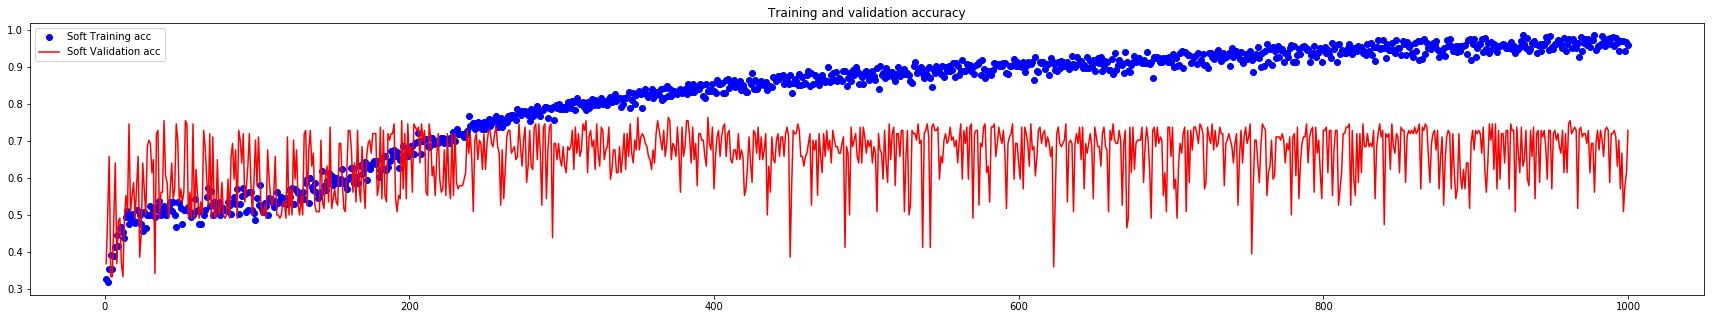

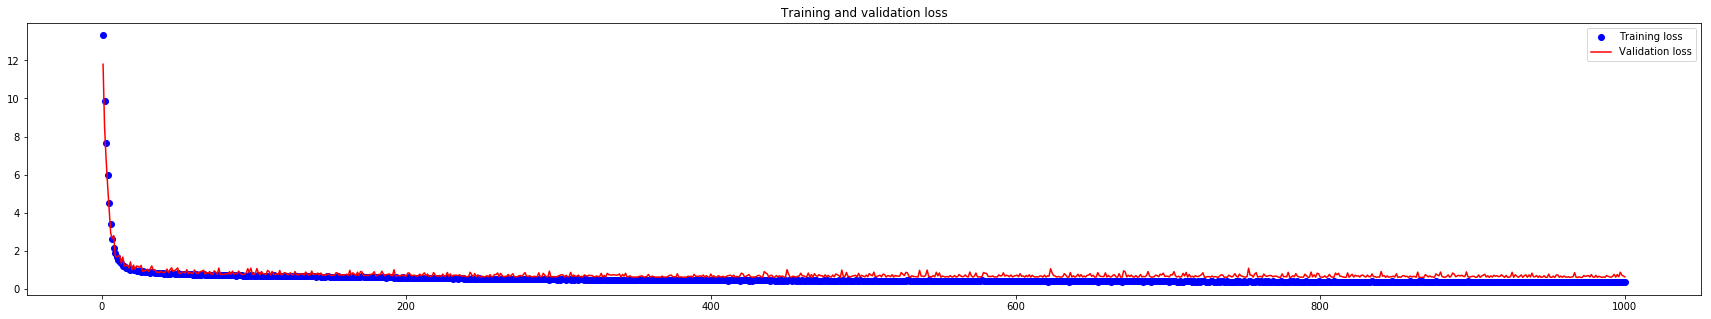

In [201]:
import matplotlib.pyplot as plt

soft_acc = history.history['soft_acc']
soft_val_acc = history.history['val_soft_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(soft_acc) + 1)
plt.figure(figsize=(30,5))
plt.plot(epochs, soft_acc, 'bo', label='Soft Training acc')
plt.plot(epochs, soft_val_acc, 'r', label='Soft Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(figsize=(30,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()




### Evaluation on old dataset

In [203]:
print(model.evaluate(old_data, old_tags))
print(model.metrics_names)

183/183 [==============================] - 0s 361us/step
[1.201306827732774, 0.39890710423227216]
['loss', 'soft_acc']


### 10 Fold Validation

In [173]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvs_scores = []
for train, test in kfold.split(data, tags):
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(1000,45)))
    model.add(MaxPooling1D(10))
    model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1))
    def soft_acc(y_true, y_pred):
        from tensorflow.python.keras import backend as K
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))
    model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
    model.fit(data[train], tags[train], epochs=1000, verbose=0)
    scores = model.evaluate(data[test], tags[test], verbose=0)
    print(scores[1]*100)
    cvs_scores.append(scores[1]*100)
print("Accuracy:", np.mean(cvs_scores),"std:", np.std(cvs_scores))

56.140351138616865
57.89473694667482
52.63157999306395
50.87719214589972
52.63157905193797
57.89473637154228
43.85964901823747
47.3684220983271
64.91228080632393
38.88888888888889
Accuracy: 52.3099416459513 std: 7.169945961380023
